# Get Passer Rating data by Play from DB

In [157]:
import mysql.connector
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.mlab as mlab
from mysql.connector import errorcode
import matplotlib.pyplot as plt

%matplotlib inline

config = {
'user': 'db_gtown_2018',
'password': 'Gtown2018',
'port': '3306',
'host': 'nflnumbers.czuayagz62va.us-east-1.rds.amazonaws.com',
'database': 'db_nfl',
'raise_on_warnings': True,
}
 
try:
    cnx = mysql.connector.connect(**config)
    cursor = cnx.cursor()
    #Let's read all the rows in the table
    readContactPerson = """SELECT 
PASSER.PNAME AS PASSER
, CONCAT(PASSER.PNAME, ', ', GAME.SEAS) AS PASSER_SEAS
, CASE WHEN PASSER_PRO_BOWL.PLAYER_ID IS NOT NULL
THEN 1
ELSE 0
END AS PASSER_PRO_BOWL

, CASE WHEN PASSER.DPOS > 0
THEN PASSER.DPOS
ELSE 256
END AS PASSER_DRAFT_SPOT
, CASE WHEN PASSER.DPOS > 0
THEN 1
ELSE 0
END AS PASSER_DRAFTED 

,TARGET.PNAME AS TARGET
,CASE WHEN PASS_FULL.LOC IN ('DL', 'DM', 'DR')
THEN 1
ELSE 0
END AS DEEP_PASS
,CASE WHEN PASS_FULL.LOC IN ('L', 'M', 'R', 'NL')
THEN 1
ELSE 0
END AS MED_PASS
,CASE WHEN PASS_FULL.LOC IN ('SL', 'SM', 'SR')
THEN 1
ELSE 0
END AS SHORT_PASS
, PASS_FULL.YDS
, 1 AS PASS_ATTEMPT
, PASS_FULL.COMP
, PASS_FULL.TD
, PASS_FULL.INTRCPT
, PASSER_RATING.PASS_RAT
, PASSER.HEIGHT AS PASSER_HGHT
, GAME.SEAS - RIGHT(PASSER.DOB,4) AS PASSER_AGE
, PASSER.START AS PASSER_CAREER_STRT
/*, GAME.SEAS - */
, TARGET.HEIGHT AS TGT_HGHT
, TARGET.WEIGHT AS TGT_WGHT
, CASE WHEN TARGET_PRO_BOWL.PLAYER_ID IS NOT NULL
THEN 1
ELSE 0
END AS TARGET_PRO_BOWL

, GAME.SEAS - RIGHT(TARGET.DOB,4) AS TGT_AGE
, CASE WHEN TARGET.DPOS IS NULL
THEN 256
WHEN TARGET.DPOS = 0
THEN 256
ELSE TARGET.DPOS
END AS TGT_DRAFT_SPOT
, CASE WHEN TARGET.DPOS > 0
THEN 1
ELSE 0
END AS TGT_DRAFTED 
, TARGET.START AS TGT_CAREER_STRT /*'USE TO FIGURE OUT YEARS IN LEAGUE'*/
, CASE WHEN TARGET.FORTY = 0
THEN ROUND(AVERAGE_FORTY.AVG_FORTY,3)
ELSE TARGET.FORTY
END AS TGT_FORTY
, CASE WHEN TARGET.VERTICAL = 0
THEN ROUND(AVERAGE_VERTICAL.AVG_VERT,3)
ELSE TARGET.VERTICAL
END AS TGT_VERT
, CASE WHEN TARGET.POS1 = 'RB'
THEN 1
ELSE 0
END AS RB_TGT
, CASE WHEN TARGET.POS1 = 'WR'
THEN 1
ELSE 0
END AS WR_TGT
, CASE WHEN TARGET.POS1 = 'TE'
THEN 1
ELSE 0
END AS TE_TGT
, CASE WHEN TARGET.POS1 <> 'RB'
AND TARGET.POS1 <> 'TE'
AND TARGET.POS1 <> 'WR'
THEN 1
ELSE 0
END AS TRICK_PLAY

/*,QTR
,MIN *//*'CAN BE USED FOR TWO MIN DRILL'*/
, YTG
, Case when PASS_FULL.YDS >= YTG
THEN 1
ELSE 0
END AS FIRST_DOWN_CONVERSION

, CASE WHEN ZONE = 5
THEN 1
ELSE 0
END AS RED_ZONE_ATTMPT /*'DEFINITION AVAILABLE'*/
, CASE WHEN ZONE = 5
THEN PASSER_RATING.PASS_RAT
ELSE NULL
END AS RED_ZONE_QB_RAT /*'DEFINITION AVAILABLE'*/
, CASE WHEN DWN = 4
AND PASS_FULL.YDS >= YTG
THEN 1
when DWN = 4
AND PASS_FULL.YDS < YTG
THEN 0
ELSE NULL
END
AS FOURTH_DOWN_SUCCESS
, CASE WHEN DWN = 3
AND PASS_FULL.YDS >= YTG
THEN 1
when DWN = 3
AND PASS_FULL.YDS < YTG
THEN 0
ELSE NULL
END
AS THIRD_DOWN_SUCCESS
, CASE WHEN QTR = 4
THEN PASSER_RATING.PASS_RAT
ELSE null
END AS FOURTH_QTR_PASS_RAT
, CASE WHEN SG = 'Y'
THEN 1 
ELSE 0
END as SHOTGUN
, CASE WHEN NH = 'Y'
THEN 1
ELSE 0
END AS  NO_HUDDLE
, CASE WHEN PENALTY.ACT IS NOT NULL
THEN 1
ELSE 0
END AS DEF_PENALTY_DCLND
,CASE WHEN PENALTY.ACT IS NOT NULL
THEN PASSER_RATING.PASS_RAT
ELSE NULL
END AS FREE_PLAY_PASS_RAT
, PENALTY.DESC as PENALTY_DESC
,GAME.SEAS
/* ,GAME.WK
,GAME.DAY
,GAME.V 'FIGURE OUT HOW TO DO HOME OR AWAY'
,GAME.H*/
/*HOW DO WE CALCULATE WHETHER THE PASSER IS AT HOME OR AWAY?*/
,GAME.TEMP
,GAME.HUMD
,GAME.WSPD
,case when COND IN ('Rain', 'Showers', 'Snow', 'Thunderstorms', 'Cold'
,'Flurries'
,'Light Rain'
,'Light Showers'
,'Light Snow'
,'Windy'
)
THEN 1
ELSE 0
END AS BAD_WEATH
, case when COND IN ('Chance Rain'
,'Clear'
,'Closed Roof'
,'Cloudy'
,'Covered Roof'
,'Dome'
,'Fair'
,'Foggy'
,'Hazy'
,'Mostly Cloudy'
,'Mostly Sunny'
,'Overcast'
,'Partly Cloudy'
,'Partly Sunny'
,'Sunny' )
THEN 1
WHEN COND IS NULL
THEN 1
ELSE 0
END AS GOOD_WEATH
,GAME.COND
, CASE WHEN GAME.COND = 'DOME'
THEN 1
ELSE 0
END AS DOME_GAME
, CASE WHEN GAME.SURF <> 'GRASS'
THEN 1
ELSE 0
END AS TURF_FIELD
 FROM PBP
 INNER JOIN PASS_FULL
 ON PBP.PID = PASS_FULL.PID
left outer join GAME
ON PBP.GID = GAME.GID
LEFT OUTER JOIN PENALTY
ON PBP.PID = PENALTY.PID
AND PENALTY.CAT = '4'
AND PENALTY.ACT = 'D'
INNER JOIN PLAYER PASSER
ON PASS_FULL.PSR = PASSER.PLAYER
LEFT OUTER JOIN PLAYER TARGET
ON PASS_FULL.TRG = TARGET.PLAYER
LEFT OUTER JOIN PASSER_RATING
ON PASS_FULL.YDS = PASSER_RATING.YDS
AND PASS_FULL.COMP = PASSER_RATING.COMPL
AND PASS_FULL.TD = PASSER_RATING.TD
AND PASS_FULL.INTRCPT = PASSER_RATING.INTRCPT
LEFT OUTER JOIN (SELECT 
POS1
, AVG(FORTY) AS AVG_FORTY
,COUNT(*)
FROM PLAYER
WHERE FORTY > 0
GROUP BY 
POS1) AVERAGE_FORTY
ON TARGET.POS1 = AVERAGE_FORTY.POS1
LEFT OUTER JOIN
(SELECT 
POS1
, AVG(VERTICAL) AS AVG_VERT
,COUNT(*)
FROM PLAYER
WHERE VERTICAL > 0
GROUP BY 
POS1) AVERAGE_VERTICAL
ON TARGET.POS1 = AVERAGE_VERTICAL.POS1
LEFT OUTER JOIN PRO_BOWL PASSER_PRO_BOWL
ON GAME.SEAS = PASSER_PRO_BOWL.ProBowl_Year
AND PASSER.PLAYER = PASSER_PRO_BOWL.PLAYER_ID
LEFT OUTER JOIN PRO_BOWL TARGET_PRO_BOWL
ON GAME.SEAS = TARGET_PRO_BOWL.ProBowl_Year
AND TARGET.PLAYER = TARGET_PRO_BOWL.PLAYER_ID
WHERE PASS_FULL.SPK = 0
AND GAME.SEAS < 2017


"""
    cursor.execute(readContactPerson)
    #specify the attributes that you want to display
    df = DataFrame(cursor.fetchall())    
    
    cnx.commit()
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(err)
else:
    cursor.close()
    cnx.close()

In [158]:
df.columns = ['PASSER', 
'PASSER_SEAS',
'PASSER_PRO_BOWL', 
'PASSER_DRAFT_SPOT', 
'PASSER_DRAFTED', 
'TARGET', 
'DEEP_PASS', 
'MED_PASS', 
'SHORT_PASS', 
'YDS', 
'PASS_ATTEMPT',
'COMP', 
'TD', 
'INTRCPT', 
'PASS_RAT', 
'PASSER_HGHT', 
'PASSER_AGE', 
'PASSER_CAREER_STRT', 
'TGT_HGHT', 
'TGT_WGHT', 
'TARGET_PRO_BOWL', 
'TGT_AGE', 
'TGT_DRAFT_SPOT', 
'TGT_DRAFTED', 
'TGT_CAREER_STRT', 
'TGT_FORTY', 
'TGT_VERT', 
'RB_TGT', 
'WR_TGT', 
'TE_TGT', 
'TRICK_PLAY', 
'YTG', 
'FIRST_DOWN_CONVERSION', 
'RED_ZONE_ATTMPT', 
'RED_ZONE_QB_RAT', 
'FOURTH_DOWN_SUCCESS', 
'THIRD_DOWN_SUCCESS', 
'FOURTH_QTR_PASS_RAT', 
'SHOTGUN', 
'NO_HUDDLE', 
'DEF_PENALTY_DCLND', 
'FREE_PLAY_PASS_RAT', 
'PENALTY_DESC', 
'SEAS', 
'TEMP', 
'HUMD', 
'WSPD', 
'BAD_WEATH', 
'GOOD_WEATH', 
'COND', 
'DOME_GAME', 
'TURF_FIELD'
]

In [159]:
df.head(5)

,PASSER,PASSER_SEAS,PASSER_PRO_BOWL,PASSER_DRAFT_SPOT,PASSER_DRAFTED,TARGET,DEEP_PASS,MED_PASS,SHORT_PASS,YDS,...,PENALTY_DESC,SEAS,TEMP,HUMD,WSPD,BAD_WEATH,GOOD_WEATH,COND,DOME_GAME,TURF_FIELD
0,V.Testaverde,"V.Testaverde, 2000",0,1,1,M.Coleman,0,1,0,45,...,None,2000,68,74,12,0,0,,0,0
1,P.Manning,"P.Manning, 2000",1,1,1,K.Dilger,0,1,0,0,...,None,2000,90,50,8,0,1,Mostly Sunny,0,0
2,P.Manning,"P.Manning, 2000",1,1,1,K.Dilger,0,1,0,0,...,None,2000,90,50,8,0,1,Mostly Sunny,0,0
3,C.McNown,"C.McNown, 2000",0,12,1,C.Villarrial,0,1,0,0,...,None,2000,65,0,0,0,1,Dome,1,1
4,P.Manning,"P.Manning, 2000",1,1,1,K.Dilger,0,1,0,6,...,None,2000,90,50,8,0,1,Mostly Sunny,0,0


## Per Pass passer rating distribution

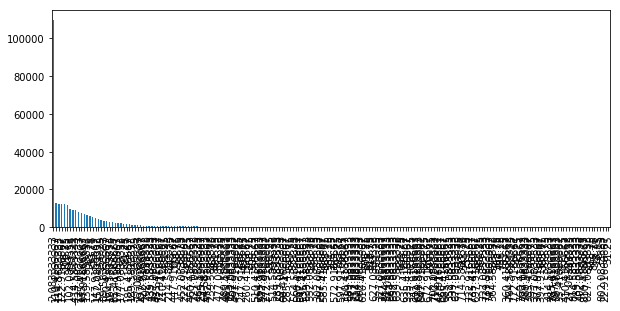

In [160]:
plt.figure(figsize=(10,4))
df["PASS_RAT"].value_counts().plot(kind='bar')

In [161]:
#Too many pass attemps, lets group them group into a per season/passer
#df.groupby(['PASSER', 'SEAS']).size()

df_passer_by_season = df.groupby(['PASSER', 'SEAS']).agg({
    'PASSER': np.min, 
    'PASSER_SEAS': np.min, 
    'PASSER_PRO_BOWL': np.max, 
    'PASS_RAT': np.mean, 
    'PASS_ATTEMPT': np.size,
    'COMP': np.sum,
    'PASSER_DRAFT_SPOT': np.max, 
    'PASSER_DRAFTED': np.max, 
    'DEEP_PASS': np.mean,  
    'MED_PASS': np.mean, 
    'SHORT_PASS': np.mean, 
    'YDS': np.sum, 
    'TD': np.sum, 
    'INTRCPT': np.sum, 
    'PASSER_HGHT': np.max,  
    'PASSER_AGE': np.max, 
    'PASSER_CAREER_STRT': np.max, 
    'TGT_HGHT': np.mean, 
    'TGT_WGHT': np.mean, 
    'TARGET_PRO_BOWL': np.mean,  
    'TGT_AGE': np.mean, 
    'TGT_DRAFT_SPOT': np.mean, 
    'TGT_DRAFTED': np.mean, 
    'TGT_CAREER_STRT': np.mean, 
    'TGT_FORTY': np.mean,  
    'TGT_VERT':np.mean, 
    'RB_TGT': np.mean,  
    'WR_TGT': np.mean, 
    'TE_TGT': np.mean,  
    'TRICK_PLAY': np.mean, 
    'FIRST_DOWN_CONVERSION': np.mean, 
    'RED_ZONE_ATTMPT': np.mean, 
    'RED_ZONE_QB_RAT': np.mean , 
    'FOURTH_DOWN_SUCCESS': np.mean, 
    'THIRD_DOWN_SUCCESS': np.mean, 
    'FOURTH_QTR_PASS_RAT': np.mean,  
    'SHOTGUN': np.mean,  
    'NO_HUDDLE': np.mean, 
    'DEF_PENALTY_DCLND': np.sum, 
    'FREE_PLAY_PASS_RAT': np.mean,  
    'SEAS': np.max,  
    'GOOD_WEATH': np.mean,  
    'DOME_GAME': np.mean,  
    'TURF_FIELD': np.mean,                               
    'SEAS': np.min,
                                   })


##df_passer_by_season = df.groupby(['PASSER', 'SEAS']).agg({'PASSER': { 'PASSER_NAME': np.min, 'PASS_ATTEMPTS': np.size}, 'PASSER_PRO_BOWL': np.max, 'PASS_RAT': np.mean, 'COMP': np.sum,  'PASSER_DRAFT_SPOT': np.max, 'PASSER_DRAFTED': np.max, 'DEEP_PASS': np.mean,  'MED_PASS': np.mean, 'SHORT_PASS': np.mean, 'YDS': np.sum, 'TD': np.sum, 'INTRCPT': np.sum, 'PASSER_HGHT': np.max,  'PASSER_AGE': np.max, 'PASSER_CAREER_STRT': np.max, 'TGT_HGHT': np.mean, 'TGT_WGHT': np.mean, 'TARGET_PRO_BOWL': np.mean,  'TGT_AGE': np.mean, 'TGT_DRAFT_SPOT': np.mean, 'TGT_DRAFTED': np.mean, 'TGT_CAREER_STRT': np.mean, 'TGT_FORTY': np.mean,  'TGT_VERT':np.mean, 'RB_TGT': np.mean,  'WR_TGT': np.mean, 'TE_TGT': np.mean,  'TRICK_PLAY': np.mean, 'FIRST_DOWN_CONVERSION': np.mean, 'RED_ZONE_ATTMPT': np.mean, 'RED_ZONE_QB_RAT': np.mean , 'FOURTH_DOWN_SUCCESS': np.mean, 'THIRD_DOWN_SUCCESS': np.mean, 'FOURTH_QTR_PASS_RAT': np.mean,  'SHOTGUN': np.mean,  'NO_HUDDLE': np.mean, 'DEF_PENALTY_DCLND': np.sum, 'FREE_PLAY_PASS_RAT': np.mean,  'SEAS': np.max,  'GOOD_WEATH': np.mean,  'DOME_GAME': np.mean,  'TURF_FIELD': np.mean,                               
##                                   })


df_passer_by_season
#PASS_RAT.mean()
#        'YTG': np.mean,  
## YTG is a problem - investigate why
#  Temp is problems too
# 'HUMD': np.mean, 'WSPD': np.mean, 'BAD_WEATH': np.mean,
 





#df_pass_summ = pd.DataFrame(df_pass_loc)

##df_pass_summ.plot.bar()


PASSER           PASSER_SEAS  PASSER_PRO_BOWL  \
PASSER         SEAS                                                          
A.Andrews      2015       A.Andrews       A.Andrews, 2015                0   
A.Battle       2005        A.Battle        A.Battle, 2005                0   
               2006        A.Battle        A.Battle, 2006                0   
A.Boldin       2003        A.Boldin        A.Boldin, 2003                1   
               2005        A.Boldin        A.Boldin, 2005                1   
               2010        A.Boldin        A.Boldin, 2010                0   
               2013        A.Boldin        A.Boldin, 2013                0   
               2014        A.Boldin        A.Boldin, 2014                0   
A.Brooks       2000        A.Brooks        A.Brooks, 2000                0   
               2001        A.Brooks        A.Brooks, 2001                0   
               2002        A.Brooks        A.Brooks, 2002                0   
               2003        A.Brooks        A.Brooks, 2003                0   
               2004        A.Brooks        A.Brooks, 2004                0   
               2005        A.Brooks        A.Brooks, 2005                0   
               2006        A.Brooks        A.Brooks, 2006                0   
A.Brown        2012         A.Brown         A.Brown, 2012                0   
               2013         A.Brown         A.Brown, 2013                1   
               2014         A.Brown         A.Brown, 2014                1   
A.Cason        2003         A.Cason         A.Cason, 2003                0   
A.Dalton       2011        A.Dalton        A.Dalton, 2011                0   
               2012        A.Dalton        A.Dalton, 2012                0   
               2013        A.Dalton        A.Dalton, 2013                0   
               2014        A.Dalton        A.Dalton, 2014                1   
               2015        A.Dalton        A.Dalton, 2015                0   
               2016        A.Dalton        A.Dalton, 2016                1   
A.Davis        2014         A.Davis         A.Davis, 2014                0   
               2015         A.Davis         A.Davis, 2015                0   
A.Echemandu    2004     A.Echemandu     A.Echemandu, 2004                0   
A.Edwards      2010       A.Edwards       A.Edwards, 2010                0   
               2011       A.Edwards       A.Edwards, 2011                0   
...                             ...                   ...              ...   
T.Tupa         2001          T.Tupa          T.Tupa, 2001                0   
               2002          T.Tupa          T.Tupa, 2002                0   
T.Way          2016           T.Way           T.Way, 2016                0   
T.Yates        2011         T.Yates         T.Yates, 2011                0   
               2012         T.Yates         T.Yates, 2012                0   
               2013         T.Yates         T.Yates, 2013                0   
               2014         T.Yates         T.Yates, 2014                0   
               2015         T.Yates         T.Yates, 2015                0   
V.Testaverde   2000    V.Testaverde    V.Testaverde, 2000                0   
               2001    V.Testaverde    V.Testaverde, 2001                0   
               2002    V.Testaverde    V.Testaverde, 2002                0   
               2003    V.Testaverde    V.Testaverde, 2003                0   
               2004    V.Testaverde    V.Testaverde, 2004                0   
               2005    V.Testaverde    V.Testaverde, 2005                0   
               2006    V.Testaverde    V.Testaverde, 2006                0   
               2007    V.Testaverde    V.Testaverde, 2007                0   
V.Young        2006         V.Young         V.Young, 2006                1   
               2007         V.Young         V.Young, 2007                0   
               2008         V.Young         V.Young

Text(0,0.5,'Passer Rating')

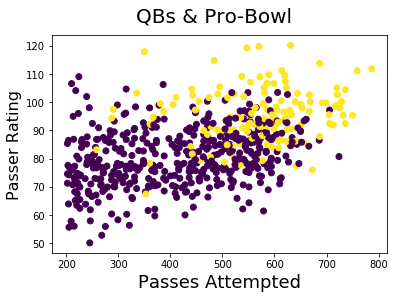

In [162]:
import matplotlib.pyplot as plt



df_passer_by_season_qb = df_passer_by_season.loc[df_passer_by_season['PASS_ATTEMPT'] > 200]


 
plt.scatter(df_passer_by_season_qb.PASS_ATTEMPT, df_passer_by_season_qb.PASS_RAT , c=df_passer_by_season_qb.PASSER_PRO_BOWL)
plt.suptitle('QBs & Pro-Bowl', fontsize=20)
plt.xlabel('Passes Attempted', fontsize=18)
plt.ylabel('Passer Rating', fontsize=16)

In [123]:
##Interactive chart attempt 1

import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets

layout = go.Layout(
    title = 'QBs & ProBowl',
    yaxis = dict(
            title='Passer Rating'
    ),
    xaxis = dict(
            title='Passes Attempted'
    ),
)

scatter1 = go.Scatter(
    x=df_passer_by_season_qb.PASSER,
    y=df_passer_by_season_qb.PASS_RAT,
    mode='markers',)

fig1 = go.Figure(data=[scatter1], layout=layout)
py.offline.iplot(fig1)

In [90]:
##Interactive chart attempt number 2

fig = {
    'data': [
  		{
  			'x': df_passer_by_season_qb.PASSER, 
        	'y': df_passer_by_season_qb.PASS_RAT, 
        	'text': df_passer_by_season_qb.PASS_RAT, 
        	'mode': 'markers', 
        	'name': '2000-2017'},
      ],
    'layout': {
        'xaxis': {'title': 'Pass Attempts', 'type': 'log'},
        'yaxis': {'title': "QB Rating"}
    }
}

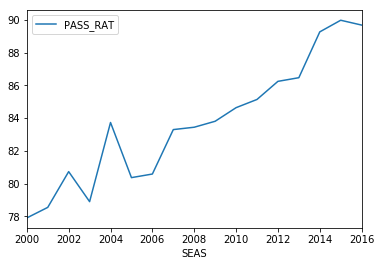

In [91]:
#lets group passes into season average over time
df_pass_seas_avg = df.groupby('SEAS').PASS_RAT.mean()
df_pass_trend = pd.DataFrame(df_pass_seas_avg)

df_pass_trend.plot()


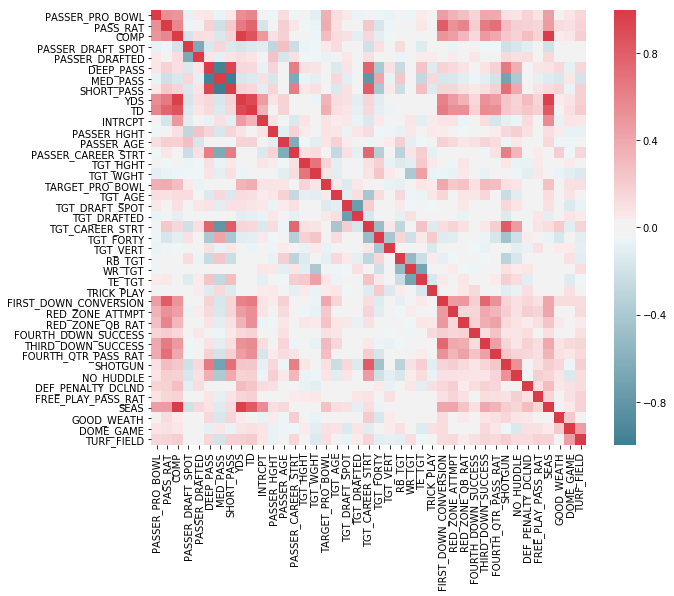

In [129]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df_passer_by_season_qb.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [173]:
import plotly
plotly.tools.set_credentials_file(username='GTown2018', api_key='MMethJca31qEJ51J4Kan')

import plotly.plotly as py
import plotly.graph_objs as go


df_passer_by_season_probowl = df_passer_by_season.loc[(df_passer_by_season['PASS_ATTEMPT'] > 100) & (df_passer_by_season['PASSER_PRO_BOWL'] == 1)]
df_passer_by_season_qb_non_pb = df_passer_by_season.loc[(df_passer_by_season['PASS_ATTEMPT'] > 100) & (df_passer_by_season['PASSER_PRO_BOWL'] == 0)]


# Create a trace
trace0 = go.Scatter(
    x = df_passer_by_season_probowl.PASS_ATTEMPT,
    y = df_passer_by_season_probowl.PASS_RAT,
    mode = 'markers',
    name = 'Pro-Bowler',
        marker = dict(
        size = 10,
        color = 'rgba(152, 0, 0, .8)'),
    text= (df_passer_by_season_probowl['PASSER_SEAS'])

)

trace1 = go.Scatter(
    x = df_passer_by_season_qb_non_pb.PASS_ATTEMPT,
    y = df_passer_by_season_qb_non_pb.PASS_RAT,
    mode = 'markers',
    name = 'Non Pro-Bowler',
        marker = dict(
        size = 5,
        color = 'rgba(0, 152, 200, .8)'),
    text= df_passer_by_season_qb_non_pb['PASSER_SEAS']

)


layout = go.Layout(
    title='QBs & ProBowls',
    xaxis=dict(
        title='Passes Attempted',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Passer Rating',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)



#data = [trace0, trace1]

scatter_pb = go.Figure(data = [trace0, trace1], layout=layout)

# Plot and embed in ipython notebook!
#py.iplot(data)
py.iplot(scatter_pb)


In [147]:
df_passer_by_season_probowl.sort_values(by=['PASS_RAT'], ascending=False)

PASSER  PASSER_PRO_BOWL    PASS_RAT  COMP  \
PASSER           SEAS                                                        
M.Ryan           2016            M.Ryan                1  120.136688   443   
P.Manning        2004         P.Manning                1  119.722222   390   
A.Rodgers        2011         A.Rodgers                1  119.200244   369   
N.Foles          2013           N.Foles                1  117.869048   226   
T.Romo           2014            T.Romo                1  114.764118   338   
T.Brady          2007           T.Brady                1  113.752426   475   
P.Manning        2013         P.Manning                1  111.853265   541   
D.Brees          2009           D.Brees                1  111.203855   435   
                 2011           D.Brees                1  111.119346   541   
A.Rodgers        2014         A.Rodgers                1  109.716327   384   
D.Culpepper      2004       D.Culpepper                1  109.455645   422   
T.Brady          2010           T.Brady                1  109.151924   353   
                 2016           T.Brady                1  108.952506   384   
A.Rodgers        2012         A.Rodgers                1  107.330247   420   
R.Wilson         2015          R.Wilson                1  107.071278   373   
P.Rivers         2013          P.Rivers                1  106.676621   408   
B.Favre          2009           B.Favre                1  106.640190   406   
D.Prescott       2016        D.Prescott                1  105.398111   335   
P.Manning        2012         P.Manning                1  105.092964   428   
A.Rodgers        2009         A.Rodgers                1  105.079023   378   
T.Brady          2011           T.Brady                1  105.040509   476   
D.Brees          2004           D.Brees                1  104.672147   293   
A.Rodgers        2016         A.Rodgers                1  104.398777   481   
D.McNabb         2004          D.McNabb                1  103.218391   368   
B.Griese         2000          B.Griese                1  103.177861   216   
B.Roethlisberger 2014  B.Roethlisberger                1  103.157350   439   
P.Manning        2005         P.Manning                1  102.889511   327   
P.Rivers         2009          P.Rivers                1  102.880019   344   
D.Brees          2013           D.Brees                1  102.643897   490   
                 2016           D.Brees                1  102.576837   471   
...                                 ...              ...         ...   ...   
T.Brady          2013           T.Brady                1   87.830543   417   
M.Hasselbeck     2003      M.Hasselbeck                1   87.211999   338   
E.Manning        2012         E.Manning                1   87.189055   321   
J.Cutler         2008          J.Cutler                1   86.526416   384   
D.Bledsoe        2002         D.Bledsoe                1   86.232182   375   
M.Stafford       2014        M.Stafford                1   86.196698   391   
P.Manning        2002         P.Manning                1   86.067499   406   
A.Luck           2013            A.Luck                1   85.645325   392   
J.Winston        2015         J.Winston                1   85.158693   312   
D.McNabb         2001          D.McNabb                1   84.975825   345   
T.Brady          2001           T.Brady                1   84.884578   324   
D.Anderson       2007        D.Anderson                1   84.348908   298   
D.McNabb         2002          D.McNabb                1   84.268223   257   
B.Favre          2002           B.Favre                1   84.044200   361   
E.Manning        2008         E.Manning                1   83.994905   304   
D.Garrard        2009         D.Garrard                1   83.930312   314   
J.Garcia         2002          J.Garcia                1   83.826754   377   
V.Young          2009           V.Young                1   83.139535   152   
A.Dalton         2014          A.Dalton                

In [36]:
WeatherConditionsDifficultyLevel = {
    'unknown': '',
    'normal':['Closed Roof','Covered Roof','Dome','Clear','Cloudy',
              'Partly Cloudy','Mostly Cloudy','Fair','Partly CLoudy',
              'Sunny','Mostly Sunny','Partly Sunny'],
    'hard':['Chance Rain','Light Rain','Flurries','Light Snow','Light Showers'],
    'extreme':['Rain','Showers','Snow','Foggy','Hazy','Thunderstorms','Cold',
               'Windy','Overcast']
}

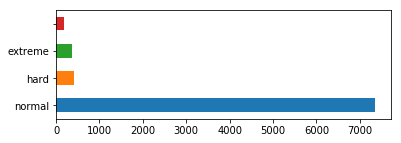

In [6]:
def multiple_replace(dict, text):
    for k,v in dict.items():        
        for val in dict[k]:
            if(val == text):
                return k
    return text
dfc = df.apply(lambda row: multiple_replace(WeatherConditionsDifficultyLevel, row['COND']), axis=1)
df["WeatherCondition"] = dfc
plt.figure(figsize=(6,2))
df["WeatherCondition"].value_counts().plot(kind='barh')

Let's see wheather effect on success counts

In [7]:
ddf = pd.DataFrame(df.groupby(['WeatherCondition'])['BLOCKED_COUNT','SUCCESS_COUNT','COUNT'].sum())

In [8]:
ddf['%']=(ddf['SUCCESS_COUNT']/ddf['COUNT'])*100

KeyError: 'SUCCESS_COUNT'

In [ ]:
ddf

In [ ]:
ddf.boxplot

## SURF

In [ ]:
df["SURF"].value_counts().plot(kind='barh')

In [ ]:
df.groupby(['FKICKER','SURF'])['SUCCESS_COUNT','COUNT'].sum()

In [ ]:
df["YEARS_PLAYED"].describe()

## Find correlation amoung all columns

In [9]:
df[['SUCCESS_PERCENTAGE','SUCCESS_COUNT','BLOCKED_COUNT','HIGH_PRESSURE_COUNT','COUNT','TEMP','HUMD','WSPD','YEARS_PLAYED','height','weight','forty','bench','vertical','broad','shuttle','cone','arm','hand','dcp','DRAFT_POSITION','AGE_YEARS']]=df[['SUCCESS_PERCENTAGE','SUCCESS_COUNT','BLOCKED_COUNT','HIGH_PRESSURE_COUNT','COUNT','TEMP','HUMD','WSPD','YEARS_PLAYED','height','weight','forty','bench','vertical','broad','shuttle','cone','arm','hand','dcp','DRAFT_POSITION','AGE_YEARS']].apply(pd.to_numeric)

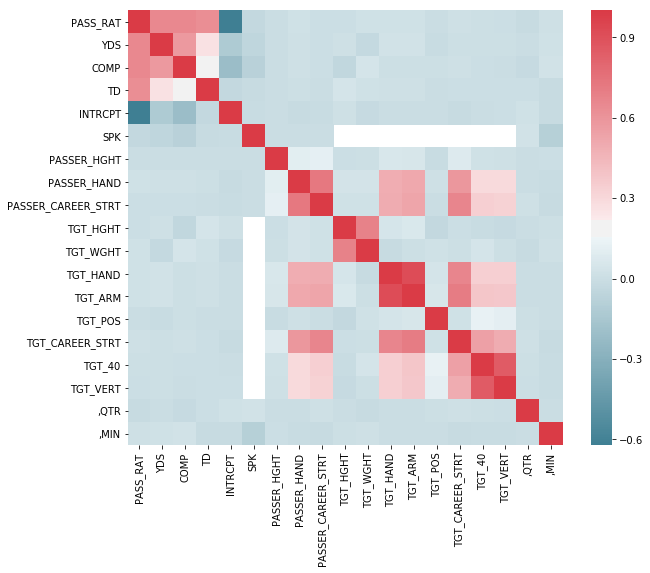

In [5]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
corr_matrix = df.corr().abs()
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var